In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import re

options = Options()
options.add_argument('--incognito') # puslapis atidaromas incognito rėžimu
driver = webdriver.Chrome(options=options) # initializinam wedriver 

# nurodomas puslapio url iš kur scrapinsim reikiamus duomenis
url = 'https://mobalytics.gg/lol/champions'
driver.get(url)

all_champions = driver.find_elements(By.CLASS_NAME, 'm-123baga') # suranda visus nurodytos klasės elementus
champions_list = [champion.text for champion in all_champions] # iteruojam per rastus elementus ir reikalingą informaciją įdedam į sąrašą

driver.quit() # užbaigiam ir uždarom driver

# sukuriam funkciją, skirtą sutvarkyti gautus names (scraping metu atsirado išskirčių, kurios nebuvo nuskaitytos, nes minimaliai skyrėsi pavadinimai)
def clean_champion_names(champions_list):
    cleaned_names = [] #sukuriam tuščią listą, kur dėsim sutvarkytus vardus
    for name in champions_list:
        if '&' in name:
            name = name.split('&')[0]
        elif 'Renata Glasc' in name:
            name = 'Renata'
        elif 'Wukong' in name:
            name = 'MonkeyKing' 
        cleaned_name = re.sub(r"[ '.]", "", name) # 're.sub' - pašalina special simbolius
        cleaned_names.append(cleaned_name) # pridedam į sąrašą
    return cleaned_names

cleaned_champions = clean_champion_names(champions_list)
print(cleaned_champions)


In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import csv

options = Options()
options.add_argument('--incognito') # puslapis atidaromas incognito rėžimu
driver = webdriver.Chrome(options=options) # initializinam wedriver 

champions = cleaned_champions # naudojam prieš tai suggeneruotą champions sąrašą
champion_ids = {} # susikuriam tuščią sąrašą, kur bus laikomi champion ids
ranks = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND', 'MASTER'] # apibūdinam naudojamus ranks
regions = ['KR', 'NA', 'EUW', 'EUNE', 'BR', 'LAN', 'OCE', 'LAS', 'PH', 'TW', 'VN'] # apibūdinam naudojamus regions
rank_ids = {'IRON': 1, 'BRONZE': 2, 'SILVER': 3, 'GOLD': 4, 'PLATINUM': 5, 'EMERALD': 6, 'DIAMOND': 7, 'MASTER': 8} # priskiriam id
region_ids = {'KR': 1, 'NA': 2, 'EUW': 3, 'EUNE': 4, 'BR': 5, 'LAN': 6, 'OCE': 7, 'LAS': 8, 'PH': 9, 'TW': 10, 'VN': 11} # priskiriam id

csv_file = open('lol_champions_data.csv', 'w', newline='', encoding='utf-8') # sukuriam csv failą, pasirenkam ką norėsim daryti (w-write, encoding-kad duomenys būtų normaliai nuskaitomi)
csv_writer = csv.writer(csv_file) # sukuriam writer objektą (surašyti duomenims į csv failą)
# sukuriam header su stulpelių pavadinimais
csv_writer.writerow(['Champion Name', 'Champion ID', 'Rank ID', 'Region ID', 'Win Rate', 'Pick Rate', 'Ban Rate', 'Matches', 'Role', 'Worst Against', 'Best Against', 'Best With', 'WR Worst Against', 'WR Best Against', 'WR Best With', 'Similar Champions'])

# iteruojam per kiekvieną champion champions sąraše
for champion in champions:
    try:
        url = f'https://mobalytics.gg/lol/champions/{champion.lower()}/build' # url puslapio iš kurio scrapinam duomenis
        driver.get(url)
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'h1'))) # palaukiam kol puslapis užsikrauna ir surandamas ieškomas tag

        # ištraukiam informaciją apie names (vardai/pavadinimai)
        name_info = driver.find_element(By.TAG_NAME, 'h1')
        name = name_info.text.split('·')[0].strip() # apsitvarkom, kad būtų tik reikalinga informacija

        # priskiriam id (eina iš eilės)
        if name not in champion_ids:
            champion_ids[name] = len(champion_ids) + 1
        champion_id = champion_ids[name]

        # ištraukiam informaciją apie roles (rolės/pozicijos)
        role_info = driver.find_element(By.CLASS_NAME, 'm-1m86nuz')
        role_full_text = role_info.text
        role = role_full_text.split('∙')[0].strip() # apsitvarkom, kad būtų tik reikalinga informacija
        
        # ištraukiam informaciją apie statistiką (names)
        vs_and_with_info = driver.find_elements(By.CLASS_NAME, 'm-v1s0fv')
        vs_and_with = [info.text for info in vs_and_with_info]
        if len(vs_and_with) < 18:
            raise Exception("Nėra pakankamai duomenų.")
        
        # išskirstom informaciją
        worst_vs_list = vs_and_with[:6]
        best_vs_list = vs_and_with[6:12]
        best_with_list = vs_and_with[12:]

        # ištraukiam informaciją apie statistiką (win rate/ laimėjimo procentas)
        wr_worst_vs_info = driver.find_elements(By.CLASS_NAME, 'm-1wtyuy0')
        wr_worst_vs = [info.text.strip('%') for info in wr_worst_vs_info]
        if len(wr_worst_vs) < 6:
            raise Exception("Nėra pakankamai duomenų.")
        
        wr_best_vs_and_best_with_info = driver.find_elements(By.CLASS_NAME, 'm-d1usi')
        wr_best_vs_and_best_with = [info.text.strip('%') for info in wr_best_vs_and_best_with_info]
        if len(wr_best_vs_and_best_with) < 12:
            raise Exception("Nėra pakankamai duomenų.")
        
        # išskirstom informaciją
        wr_best_vs_list = wr_best_vs_and_best_with[:6]
        wr_best_with_list = wr_best_vs_and_best_with[6:]

        # ištraukiam informaciją apie panašius champions
        similar_champions_info = driver.find_elements(By.CLASS_NAME, 'm-123baga')
        similar_champions = [info.text for info in similar_champions_info]

    except Exception as e:
        print(f"Klaida nuskaitant duomenis apie {champion}: {e}")
        continue

    # iteruojam per ranks (lygius) ir regions (regionus)
    for rank in ranks:
        for region in regions:
            try:
                url = f'https://mobalytics.gg/lol/champions/{champion.lower()}/build?rank={rank}&region={region}'
                driver.get(url)
                WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'm-197vfit')))

                info = driver.find_elements(By.CLASS_NAME, 'm-197vfit')
                if len(info) < 4:
                    raise Exception("Not enough rate data available.")
                
                # susirenkam statistiką, apsitvarkom duomenis (pašalinam ko nereikia, pakeičiam ką reikia)
                win_rate = info[0].text.strip('%')
                pick_rate = info[1].text.strip('%')
                ban_rate = info[2].text.strip('%')
                matches = info[3].text.replace(' ', '').replace('\n', '').strip('-')

                # priskiriam rank_id ir region_id
                rank_id = rank_ids[rank]
                region_id = region_ids[region]

                # surašom informciją į csv failą
                csv_writer.writerow([name, champion_id, rank_id, region_id, win_rate, pick_rate, ban_rate, matches, role, 
                                     ', '.join(worst_vs_list), ', '.join(best_vs_list), ', '.join(best_with_list), 
                                     ', '.join(wr_worst_vs), ', '.join(wr_best_vs_list), ', '.join(wr_best_with_list), 
                                     ', '.join(similar_champions)])
                
            # jeigu atsiranda klaida, tai atspausdinama kas nepavyko ir toliau tęsiamas duomenų scrapinimas
            except Exception as e:
                print(f"Klaida nuskaitant duomenis apie {champion} ({rank}, {region}): {e}")
                continue

driver.quit() # užbaigiam ir uždarom driver
csv_file.close() # uždarom csv failą

In [5]:
import csv

# susikuriam unikalių reikšmių setą
champion_set = set()

with open('lol_champions_data_updated.csv', 'r', encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file)
    headers = next(csv_reader) # praleidžiam header eilutę, nes ji nereikalinga šiuo metu
    
    # iteruojam per eilutes
    for row in csv_reader:
        champion_name = row[0]  
        champion_id = int(row[1])  
        champion_set.add((champion_name, champion_id))

champion_list = list(champion_set) # konvertuojam iš seto į listą

[('Renekton', 105), ('Kassadin', 58), ('Nilah', 90), ('Kennen', 62), ('Syndra', 127), ('Rell', 104), ("Kha'Zix", 63), ('Lux', 75), ('Tristana', 134), ('Sett', 114), ('Trundle', 135), ('Renata Glasc', 167), ('Fiddlesticks', 32), ('Quinn', 100), ('Varus', 141), ("Kog'Maw", 66), ("Kai'Sa", 54), ('Brand', 16), ('Mordekaiser', 82), ('Samira', 110), ('Milio', 80), ('Lucian', 73), ('Kalista', 55), ('Kled', 65), ('Nunu & Willump', 92), ('Kayn', 61), ('Talon', 130), ('Skarner', 121), ('Lissandra', 72), ('Aphelios', 9), ('Vi', 146), ('Zyra', 165), ('Jayce', 51), ('Vladimir', 149), ('Master Yi', 79), ('Zoe', 164), ('Shaco', 115), ('Kayle', 60), ('Miss Fortune', 81), ('Malzahar', 77), ('Leona', 70), ('Yasuo', 155), ('Lulu', 74), ('Azir', 12), ('Taliyah', 129), ('Yone', 156), ('Maokai', 78), ('Akali', 3), ('Nasus', 86), ('Malphite', 76), ('Xerath', 153), ('Sivir', 120), ('Karma', 56), ('Nocturne', 91), ('Twisted Fate', 137), ('Alistar', 5), ('Seraphine', 113), ('Graves', 40), ('Volibear', 150), ('F

In [1]:
import pandas as pd

df = pd.read_csv('lol_champions_data.csv')

# sukuriam žodyną ir su mapping sujungiam champion names su jų ids
champion_ids = pd.Series(df['Champion ID'].values, index=df['Champion Name']).to_dict()

# sukuriam funkciją, kuri pakeičia names į ids
def replace_names_with_ids(name_list, champion_ids):
    if pd.isna(name_list): # jeigu yra missing values, tai gražins tuščią string
        return ''
    name_list = name_list.split(', ')
    # konvertuojam kiekvieną name į atitinkamą id
    id_list = [str(champion_ids[name]) for name in name_list if name in champion_ids]
    return ', '.join(id_list)

# panaudojam susikurtą funkciją pakeičiant duomenis norimuose stulpeliuose
df['Worst Against'] = df['Worst Against'].apply(lambda x: replace_names_with_ids(x, champion_ids))
df['Best Against'] = df['Best Against'].apply(lambda x: replace_names_with_ids(x, champion_ids))
df['Best With'] = df['Best With'].apply(lambda x: replace_names_with_ids(x, champion_ids))
df['Similar Champions'] = df['Similar Champions'].apply(lambda x: replace_names_with_ids(x, champion_ids))

# sukuriam funkciją, kuri splitina sąrašus (atskirtus kableliu) į atskirus stulpelius
def split_to_columns(series, prefix):
    split_data = series.str.split(', ', expand=True)
    split_data.columns = [f"{prefix}{i+1}" for i in range(split_data.shape[1])]
    return split_data

# panaudojam susikurtą funkciją pakeičiant duomenis, dropinam nebereikalingus stulpelius, joininam naujus stulpelius 
worst_against_split = split_to_columns(df['Worst Against'], 'Worst Against ')
df = df.drop(columns=['Worst Against']).join(worst_against_split)
best_against_split = split_to_columns(df['Best Against'], 'Best Against ')
df = df.drop(columns=['Best Against']).join(best_against_split)
best_with_split = split_to_columns(df['Best With'], 'Best With ')
df = df.drop(columns=['Best With']).join(best_with_split)
similar_champions_split = split_to_columns(df['Similar Champions'], 'Similar Champion ')
df = df.drop(columns=['Similar Champions']).join(similar_champions_split)

#splitinam stulpelius
df[['WR Worst Against1', 'WR Worst Against2', 'WR Worst Against3', 'WR Worst Against4', 'WR Worst Against5', 'WR Worst Against6']] = df['WR Worst Against'].str.split(', ', expand=True)
df[['WR Best Against1', 'WR Best Against2', 'WR Best Against3', 'WR Best Against4', 'WR Best Against5', 'WR Best Against6']] = df['WR Best Against'].str.split(', ', expand=True)
df[['WR Best With1', 'WR Best With2', 'WR Best With3', 'WR Best With4', 'WR Best With5', 'WR Best With6']] = df['WR Best With'].str.split(', ', expand=True)
df.drop(columns=['WR Worst Against', 'WR Best Against', 'WR Best With'], inplace=True) # dropinam nebereikalingus stulpelius

df.to_csv('lol_champions_data_updated.csv', index=False) # išsaugom pakeitimus į csv failą

In [3]:
# mapping (sukuriam žodyną, kuriame roles turi priskirtus numerius (id))
role_mapping = {
    'Top': 1,
    'Mid': 2,
    'Jungle': 3,
    'Bot': 4,
    'Support': 5
}

df['Role'] = df['Role'].map(role_mapping) #  pakeičiam roles į skaičius stulpelyje 'Role'
df.to_csv('lol_champions_data_updated.csv', index=False) # išsaugom pokyčius

In [5]:
games_data = pd.read_csv('lol_champions_data_updated.csv')
print(games_data.dtypes)

Champion Name          object
Champion ID             int64
Rank ID                 int64
Region ID               int64
Win Rate              float64
Pick Rate             float64
Ban Rate              float64
Matches                 int64
Role                    int64
Worst Against 1         int64
Worst Against 2         int64
Worst Against 3         int64
Worst Against 4         int64
Worst Against 5         int64
Worst Against 6         int64
Best Against 1          int64
Best Against 2          int64
Best Against 3          int64
Best Against 4          int64
Best Against 5          int64
Best Against 6          int64
Best With 1             int64
Best With 2             int64
Best With 3             int64
Best With 4             int64
Best With 5             int64
Best With 6             int64
Similar Champion 1      int64
Similar Champion 2      int64
Similar Champion 3      int64
Similar Champion 4      int64
WR Worst Against1     float64
WR Worst Against2     float64
WR Worst A

In [8]:
import pandas as pd

df = pd.read_csv('lol_champions_data_updated.csv')

# pasižiūrim ar nėra neteisingų duomenų
# patikrinam reeikalavimus 
errors_found = False

# champion id - nuo 1 iki 167
if not (df['Champion ID'] >= 1).all() or not (df['Champion ID'] <= 167).all():
    print("Champion ID turi būti nuo 1 iki 167")
    errors_found = True

# rank id - nuo 1 iki 8
if not (df['Rank ID'] >= 1).all() or not (df['Rank ID'] <= 8).all():
    print("Rank ID turi būti nuo 1 iki 8")
    errors_found = True

# region id - nuo 1 iki 11
if not (df['Region ID'] >= 1).all() or not (df['Region ID'] <= 11).all():
    print("Region ID turi būti nuo 1 iki 11")
    errors_found = True

# Win, pick ir ban rates - nuo 1 iki 100%
rate_columns = ['Win Rate', 'Pick Rate', 'Ban Rate']
if not (df[rate_columns].apply(lambda x: (x >= 0) & (x <= 100)).all()).all():
    print("Win, Pick ir Ban Rates turi būti nuo 0 iki 100%")
    errors_found = True

# Matches - virš 0
if not (df['Matches'] > 0).all():
    print("Matches turi būti virš 0")
    errors_found = True

# Role - nuo 1 iki 5
if not (df['Role'] >= 1).all() or not (df['Role'] <= 5).all():
    print("Role turi būti nuo 1 iki 5")
    errors_found = True

# Worst against, best against, best with ir similar champions - nuo 1 iki 167
related_columns = ['Worst Against 1', 'Worst Against 2', 'Worst Against 3', 'Worst Against 4', 'Worst Against 5', 'Worst Against 6', 'Best Against 1', 'Best Against 2', 'Best Against 3', 'Best Against 4', 'Best Against 5', 'Best Against 6',
                   'Best With 1', 'Best With 2', 'Best With 3', 'Best With 4', 'Best With 5', 'Best With 6', 'Similar Champion 1', 'Similar Champion 2', 'Similar Champion 3', 'Similar Champion 4']
if not (df[related_columns].apply(lambda x: (x >= 1) & (x <= 167)).all()).all():
    print("Worst against, Best against ir Similar champions turi būti nuo 1 iki 167")
    errors_found = True

# Win rate best against, worst against ir best with - nuo 1 iki 100%
wr_columns = ['WR Worst Against1', 'WR Worst Against2', 'WR Worst Against3', 'WR Worst Against4', 'WR Worst Against5', 'WR Worst Against6', 'WR Best Against1', 'WR Best Against2', 'WR Best Against3', 'WR Best Against4', 'WR Best Against5', 'WR Best Against6',
              'WR Best With1', 'WR Best With2', 'WR Best With3', 'WR Best With4', 'WR Best With5', 'WR Best With6']
if not (df[wr_columns].apply(lambda x: (x >= 0) & (x <= 100)).all()).all():
    print("Win rate Best against, Worst against ir Best with turi būti nuo 0 iki 100%")
    errors_found = True

if not errors_found:
    print("Duomenys atitinka visus reikalavimus ! :) ")


Duomenys atitinka visus reikalavimus ! :) 


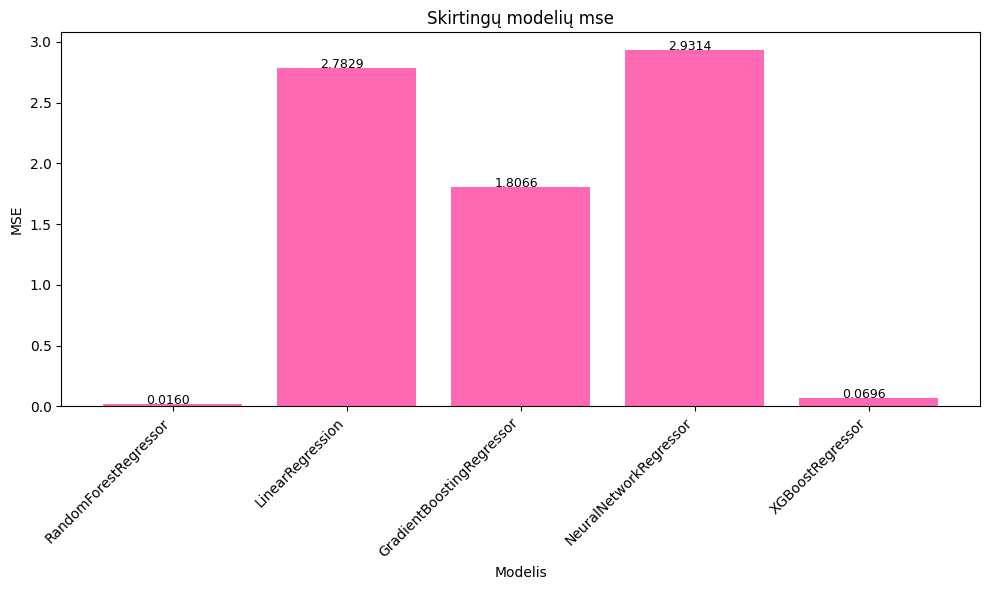

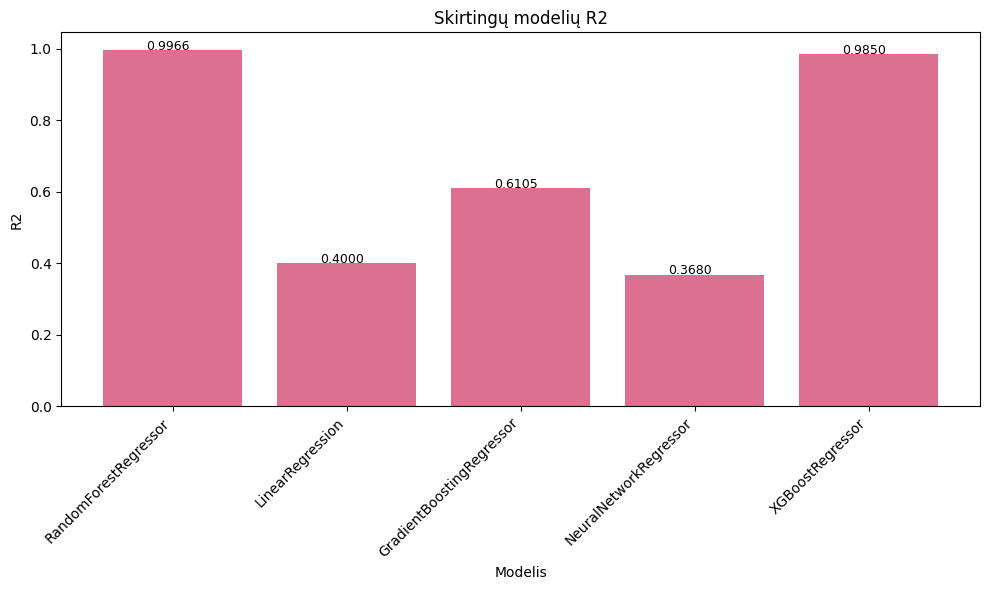

In [2]:
# Toliau ieškom kuris modelis geriausias 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

games_data = pd.read_csv('lol_champions_data_updated.csv')

#  pašalinam missing values (jeigu yra)
games_data = games_data.dropna()
# pašalinam dublikatus (jeigu yra)
games_data = games_data.drop_duplicates()

# apibūdinam features ir target (win rate) - ką norime prognozuoti
X = games_data.drop(['Win Rate', 'Champion Name'], axis=1)
y = games_data['Win Rate']

#  splitinam duomenis i mokymosi ir testavimo rinkinius (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalizuojam duomenis 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# žodynas modelių, kurių tikslumą  norime palyginti
models = {
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'NeuralNetworkRegressor': MLPRegressor(random_state=42),
    'XGBoostRegressor': XGBRegressor(random_state=42),
}

# susikuriam sąrašus sudėti modelių pavadinimus, mse ir r2 rezultatus
model_names = []
mse_scores = []
r2_scores = []

# apmokom ir įvertinam kiekvieną modelį
for name, model in models.items():
    model_names.append(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)

# mse rodikliai
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mse_scores, color='hotpink')
plt.xlabel('Modelis')
plt.ylabel('MSE')
plt.title('Skirtingų modelių mse')
plt.xticks(rotation=45, ha='right')
# prisidedam tekstą, kad matytume mse reikšmes ggrafike
for bar, mse in zip(bars, mse_scores):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.001, f'{mse:.4f}', fontsize=9)
plt.tight_layout()
plt.show()

# r2 rodikliai
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, r2_scores, color='palevioletred')
plt.xlabel('Modelis')
plt.ylabel('R2')
plt.title('Skirtingų modelių R2')
plt.xticks(rotation=45, ha='right')
# prisidedam tekstą, kad matytume r2 reikšmes ggrafike
for bar, r2 in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.001, f'{r2:.4f}', fontsize=9)
plt.tight_layout()
plt.show()

# geriausius rezultatus (mažiausias mse ir didžiausias r2) gaunam su RandomForestRegressor modeliu, todėl jį ir naudosime

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

games_data = pd.read_csv('lol_champions_data_updated.csv')

#  pašalinam missing values (jeigu yra)
games_data = games_data.dropna()
# pašalinam dublikatus (jeigu yra)
games_data = games_data.drop_duplicates()

# apibūdinam features ir target (win rate)
X = games_data.drop(['Win Rate', 'Champion Name'], axis=1)
y = games_data['Win Rate']

#  splitinam duomenis i mokymosi ir testavimo rinkinius (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalizuojam duomenis 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# pasirenkam modelį 
model = RandomForestRegressor(random_state=42)

# sukuriam hiperparametrų paieškos ruošinį
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# geriausias modelis
best_model = grid_search.best_estimator_

# atliekam spėjimus
y_pred = best_model.predict(X_test)

# įvertinam geriausią modelį
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Geriausi parametrai:", grid_search.best_params_)
print("Vidutinis kvadratinis nuokrypis (mse):", mse)
print("R-kvadratas (r2):", r2)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Geriausi parametrai: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Vidutinis kvadratinis nuokrypis (mse): 0.01520458433406604
R-kvadratas (r2): 0.9967220510081397


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

games_data = pd.read_csv('lol_champions_data_updated.csv')

# apibūdinam features ir target (win rate)
X = games_data.drop(['Win Rate', 'Champion Name'], axis=1)
y = games_data['Win Rate']

#  splitinam duomenis i mokymosi ir testavimo rinkinius (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalizuojam duomenis 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# pasirenkam modelį 
model = RandomForestRegressor(random_state=42)

# geriausi hiperparametrai
param_grid = {
    'n_estimators': [200],
    'max_depth': [30],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# geriausias modelis
best_model = grid_search.best_estimator_

# atliekam spėjimus
y_pred = best_model.predict(X_test)

# įvertinam geriausią modelį
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Geriausi parametrai:", grid_search.best_params_)
print("Vidutinis kvadratinis nuokrypis (mse):", mse)
print("R-kvadratas (r2):", r2)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Geriausi parametrai: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Vidutinis kvadratinis nuokrypis (mse): 0.01520458433406604
R-kvadratas (r2): 0.9967220510081397


In [1]:
from joblib import dump

# išsaugom geriausią modelį
dump(best_model, 'best_model.joblib')


NameError: name 'best_model' is not defined